In [3]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from extract_transect import extract_transect
#from filter_1D_profile_and_unwrap import unwrap_1D
# import something specific so that I can set gridlines to 2pi intervals 
#    without having to specifcy ylim each time I plot a different transect 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import time
%matplotlib  widget

Set up working directory, locations of pixels for comparison

In [39]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'

alooks=4; rlooks=20

# for poster perhaps, 10-31-22
x1=15000; y1=1500; x2=16500; y2=1500 # if in big section
x1=1000; y1=500; x2=2500; y2=500 
# x1,y1 are LS, x2,y2 are open desert

dx = 3000
dy = 750

Import the dates of the SLCs (as strings, then change to datetime objects)

In [18]:
# load in dates
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vv/2*")]
dates = sorted(dates)
nd = len(dates)
numIgrams = nd-1
print(str(numIgrams)+' igrams.')

210 igrams.


In [44]:
# make an array to hold igrams
igrams = np.ndarray((numIgrams,dy,dx),dtype='float')

for i in range(numIgrams):
    # define the 2 dates. 
    date1=dates[i]; date2=dates[i+1]
    # Read in the igram 
    ds = gdal.Open(igramsDir+date1+"_"+date2+"_filt_unwr.int", gdal.GA_ReadOnly)
    igrams[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)

In [45]:
# Pull out the top left 10 x 10 pixels and remove the average value for each igram 

# initialize an array for corrected igrams 
igramsCor = np.ndarray(np.shape(igrams),dtype='float')

for i in range(numIgrams):
    igramsCor[i] = igrams[i]-np.mean(igrams[i,0:10,-10::])

In [46]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[0:-1]
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt = np.zeros([len(dt1),1])
for i in range(len(dt)):
    dt[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')
#print(dt)

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


In [47]:
# Extract a transect from these igrams, can plot phase changes over time 
lenTsct = x2-x1
tscts = np.ndarray((numIgrams,lenTsct),dtype='float')
for i in range(numIgrams):
    tscts[i,:]=igramsCor[i,y1,x1:x2]

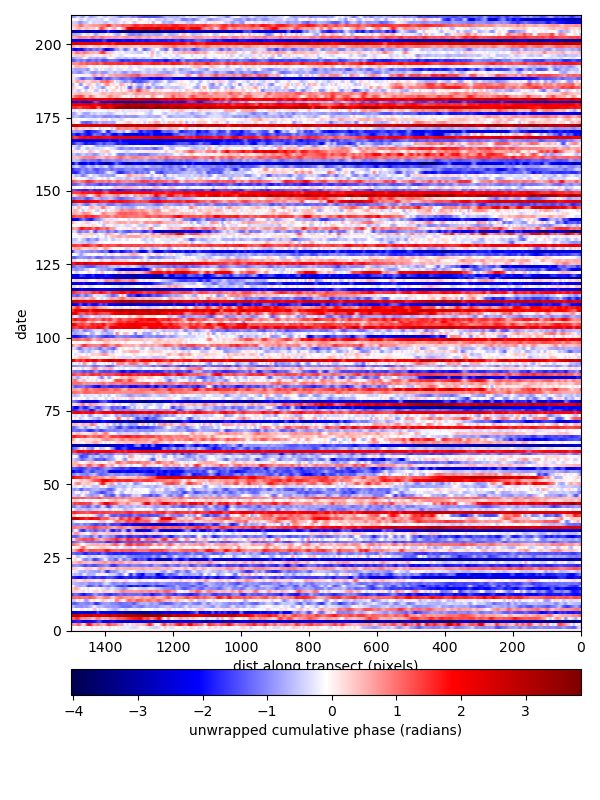

In [48]:
# plot cumulative phase transects (mean in open desert subtracted) and coherence side-by-side
plt.figure(figsize=(6,8), layout='tight') #(14,35) for my large screen
#plt.subplot(1,2,1)
plt.ylabel('date')
plt.xlabel('dist along transect (pixels)')
# only plot phases but for all igrams and for all distances along transect 
plt.pcolor(tscts,cmap='seismic')
# put a line where the TPC anomaly ends, is there a difference on each side? 
# switch this depending on the specific transect and if it crosses a feature you want to mark 
#plt.axvline(x=transition, color='k', linestyle='--')
#plt.yticks(range(numIgrams), igram_dates)
#plt.xticks(range(lenTsct), range(0::200))
#plt.xticks(np.arange(0,np.shape(UnwrTsctsCum)[2],tsctTick),np.real(UnwrTsctsCum[0,0,::tsctTick]))
cbar = plt.colorbar(orientation="horizontal",pad=0.05) # for big plots, pad=0.02 is good 
cbar.set_label('unwrapped cumulative phase (radians)')
#plt.title('mean value (in cuTPC) of each transect subtracted (vv)\nstart ('+str(x1)+','+str(y1)+') end: ('+str(x2)+','+str(y2)+ ') larger subregion')
plt.gca().invert_xaxis()
#plt.ylim([0,30])
#plt.gca().invert_yaxis()

<br><br><br><br>THIS SEPARATES OLD STUFF FROM NEW<br><br><br><br>

Initialize arrays for SLCs. Put (alooks x rlooks) extracted portion of SLC around each pixel in the arrays. <br> Indexing: [slc, azimuth, range]

In [22]:
# initializing empty arrays, they are 3 dimensional 
# will contain a layer for each date with layer containing alooks x rlooks pixels from each SLC
slcx1=np.ndarray([len(dates),alooks,rlooks],'complex')
slcx2=np.ndarray([len(dates),alooks,rlooks],'complex')
# pull out the alooks x rlooks box of pixels from pixel in Cerro Prieto geothermal field  
for i in np.arange(nd):
    ds = gdal.Open(datesDir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                   gdal.GA_ReadOnly)
    slcx1[i,:,:] = ds.GetRasterBand(1).ReadAsArray(x1-rlooks/2,y1-alooks/2,rlooks,alooks)
# do the same for the pixel just outside of CP geotherm field 
for i in np.arange(nd):
    ds = gdal.Open(datesDir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                   gdal.GA_ReadOnly)
    slcx2[i,:,:] = ds.GetRasterBand(1).ReadAsArray(x2-rlooks/2,y2-alooks/2,rlooks,alooks)

Calculate displacement between 2 pixels in each igram, and the coherence for each igram (average coherence from 2 coherence values, one from each pixel)

In [23]:
# initialize empty nd x nd array for storing coherence values for each SLC pair/igram
# phase is difference (conjugate) between  at pt 1 and pt 2
allphase=np.zeros([nd-1,1])
coh=np.zeros([nd-1,1])
# assigning integer values to SLC pairs 
numints = np.cumsum(np.arange(nd))
numints=np.max(numints)
# what does this do?
ids=np.ndarray([numints,2])
# making interferograms, looping thru i, j dates 
for i in np.arange(nd-1):
    j = i+1
    # is is first date, j is comparison date
    # Using this method: <a b*> / <abs(a b*)>
    # a b*
    ints=slcx1[i,:,:] * np.conj(slcx1[j,:,:])
    ints2=slcx2[i,:,:] * np.conj(slcx2[j,:,:])
    # take the mean over all the pixels in this area (complex space) complex coherence
    # <a b*>
    cov=np.mean(ints,axis=(0,1)) # complex number, of which phase is angle 
    # mag of this is the coherence at that point 
    cov2=np.mean(ints2,axis=(0,1))
    # <abs (a b*)>
    intmag=np.mean(np.abs(ints),axis=(0,1))
    intmag2=np.mean(np.abs(ints2),axis=(0,1))
    # coherence magnitude, simplest way of doing it 
    # <a b*> / <abs(a b*)>
    covw = cov/intmag
    covw2 = cov2/intmag2
    # put these into a 2-element array
    toAvg = [covw, covw2]
    # average the two coherence magnitudes from the two points
    coh[i] = np.mean(np.abs(toAvg))
    # now we have covs at pt 1 and 2 
    allphase[i]=np.angle(cov*np.conj(cov2))
    # angle instead of mag
    #allphase[i,j]=np.angle(covw)  
cumulative = np.cumsum(allphase)
#CONVERTING RADIANS TO CM 
# element by element multiplication, just in case
#allphase2 = np.multiply(allphase,dt2) # so this is radians/year now
dispcm = allphase*5.6/(4*np.pi) # disp/igram
ratecm = dispcm*365.25/dt2
cumulative2 = np.cumsum(dispcm,0)
# try a cumulative sum? See them go up? 
#print(np.shape(cumulative2))
#print(np.shape(disp))
avgrate = np.mean(ratecm)
print('Average rate = '+str(avgrate)+'cm/yr')

Average rate = 0.25771255721500963cm/yr


<br> Plot the disp rate and cumulative disp between the two points, colored by their coherence values. 

Calculate triplet phase closure at the two pixels (start and end points)

In [24]:
# calculate triplet phase closure
# initialize arrays
x1tpc=np.ndarray([len(dates)-2],'complex')
x2tpc=np.ndarray([len(dates)-2],'complex')
skip1 = slcx1[0:-1,:,:]*np.conj(slcx1[1:,:,:]) # makes igrams first
skip2 = slcx1[2:,:,:]*np.conj(slcx1[0:-2,:,:])
#####Could normalize all of these by amplitude before taking the mean, tooo!!!
#skip1 = skip1/abs(skip1)
#skip2 = skip2/abs(skip2)
skip1 = np.mean(skip1,axis=(1,2)) # now average them (same as downlooking)
skip2 = np.mean(skip2,axis=(1,2))
# exclude the 0th term and the last term 
for i in np.arange(0,nd-2,1):
    ab = skip1[i]
    bc = skip1[i+1]
    ca = skip2[i]
    ab = np.exp(1j*np.angle(ab)) # normalizing to length 1
    bc = np.exp(1j*np.angle(bc)) # same as bc/abs(bc)
    ca = np.exp(1j*np.angle(ca))
    x1tpc[i] = ab*bc*ca
skip1 = slcx2[0:-1,:,:]*np.conj(slcx2[1:,:,:]) # makes igrams first
skip2 = slcx2[2:,:,:]*np.conj(slcx2[0:-2,:,:])
#####Could normalize all of these by amplitude before taking the mean, tooo!!!
#skip1 = skip1/abs(skip1)
#skip2 = skip2/abs(skip2)
skip1 = np.mean(skip1,axis=(1,2)) # now average them (same as downlooking)
skip2 = np.mean(skip2,axis=(1,2))   
for i in np.arange(0,nd-2,1):
    ab = skip1[i]
    bc = skip1[i+1]
    ca = skip2[i]
    ab = np.exp(1j*np.angle(ab)) # normalizing to length 1
    bc = np.exp(1j*np.angle(bc)) # same as bc/abs(bc)
    ca = np.exp(1j*np.angle(ca))
    x2tpc[i] = ab*bc*ca

Plot cumulative disp btw the points, now colored by TPC at start point 

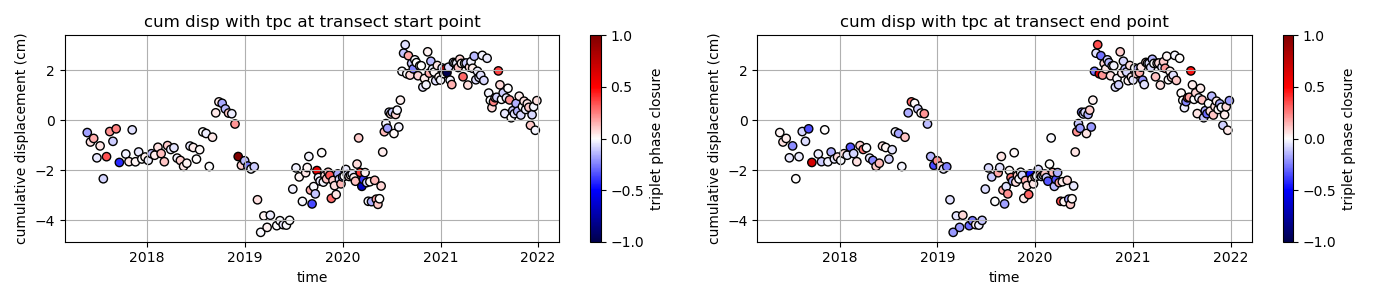

In [25]:
# plot cumulative displacement but colored by triplet phase closure at start point (on center date I believe)
plt.figure(figsize=(14, 3), tight_layout=True)
ax = plt.subplot(1, 2, 1)
plt.grid('on')
# can do one or the other, similar though 
plt.scatter(slc_dates[1:-1], cumulative2[0:-1], c=np.angle(x1tpc), vmin=-1, vmax=1, cmap='seismic', \
            edgecolors='k')
plt.clim(-1,1)
#plt.scatter(slc_dates[1:-1], cumulative2[0:-1], c=np.angle(x2tpc))
cbar = plt.colorbar()
cbar.set_label('triplet phase closure')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')
plt.title('cum disp with tpc at transect start point')
ax = plt.subplot(1, 2, 2)
plt.grid('on')
plt.scatter(slc_dates[1:-1], cumulative2[0:-1], c=np.angle(x2tpc), vmin=-1, vmax=1, cmap='seismic', \
            edgecolors='k')
cbar = plt.colorbar()
cbar.set_label('triplet phase closure')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')
plt.title('cum disp with tpc at transect end point')
plt.show()

Remember what the start and end points are this time. Can't have negative Dy or Dx, so fix that here.  <br><br>
__Still working on this (below)__

<br>Pull the dates of the SLCs we want to use for transect extracting (doesn't have to be all of them, but usually is)

In [ ]:
# what slc date do I want to start at? then convert to datetime object.
startDate = '20170510' # starting at the very beginning of time series
date1 = datetime.strptime(str(startDate).replace('\n',''), '%Y%m%d')
# find which index corresponds to this date: 
indexDate1 = slc_dates.index(date1)
print('starting at slc index '+str(indexDate1))
print(slc_dates[indexDate1])
# how many slcs do I need to load? 
numigrams = 210 # this is all of them 
numSLCs = numigrams+1 # this is all of them 
# put the dates into an array for plotting 
# str_dates are already in datetiime objects, just extract the right dates 
plotDates = str_dates[indexDate1:indexDate1+numigrams]
for i in np.arange(len(plotDates)):
    plotDates[i] = datetime.strftime(plotDates[i],'%m-%d-%Y')
# now plotDates are the slc dates
#print(plotDates)

<br> Load the SLCs within the box that encompasses the transect so we can do math on them 

In [ ]:
# loop through and load in the slcs, extract the data
if Dy > 20:
    SLCs=np.ndarray([numSLCs,Dy,Dx],'complex')
    # defined above: 
    print('shape of SLCs array: '+str(np.shape(SLCs)))
    # starts at the first date, goes through the number of igrams defined above
    for i in np.arange(indexDate1, indexDate1+numSLCs):    
        ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
        SLCs[i-indexDate1,:,:] = ds.GetRasterBand(1).ReadAsArray(x1new,y1new,Dx,Dy)
        #print('slc '+str(i))  
    # now we have all the SLCs extracted, make igrams 
    igrams = SLCs[0:-1,:,:]*np.conj(SLCs[1:,:,:])
    print('igrams made for small area')
    print('shape of igrams array: '+str(np.shape(igrams)))
    #print(type(igrams[0,0,0])) # making sure correct type of data in array 
# if the transect is horizontal, need to pull out a box that is 20 tall centered on y coord
elif Dy == 0:
    Dy = 20
    SLCs=np.ndarray([numSLCs,Dy,Dx],'complex')
    # defined above: 
    print('shape of SLCs array: '+str(np.shape(SLCs)))
    # starts at the first date, goes through the number of igrams defined above
    for i in np.arange(indexDate1, indexDate1+numSLCs):    
        ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
        SLCs[i-indexDate1,:,:] = ds.GetRasterBand(1).ReadAsArray(x1new,y1new-10,Dx,Dy)
        #print('slc '+str(i))  
    # now we have all the SLCs extracted, make igrams 
    igrams = SLCs[0:-1,:,:]*np.conj(SLCs[1:,:,:])
    print('igrams made for small area')
    print('shape of igrams array: '+str(np.shape(igrams)))
    #print(type(igrams[0,0,0])) # making sure correct type of data in array 

<br>Plot the extracted region to make sure it looks like part of an igram 

In [ ]:
# now single igram to make sure it worked 
plt.figure(figsize=(6, 4))
plt.imshow(np.angle(igrams[118]),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', \
           interpolation='nearest')
plt.plot([0,x2-x1],[10,10],'k-')
plt.ylabel('azimuth')
plt.xlabel('range')
plt.colorbar()
plt.show()
# great, it worked!

Extract and unwrap a single transect with specific parameters to look closely at the noisy/suspicious/improperly unwrapped ones

In [ ]:
# start by just doing one transect to test it 
igram_to_extract = 73 # commonly issues at 46, 73?, 101, 191?, sometimes 118, 119, 180
perpDist = 3
binSize = 10
if y2-y1 != 0:
    start1 = [0,0]
    end1 = [x2-x1,y2-y1]
    transectTest = extract_transect(igrams[igram_to_extract], start1, end1, perpDist, binSize)
elif y2-y1 == 0:
    start1 = [0,10]
    end1 = [x2-x1,10]
    transectTest = extract_transect(igrams[igram_to_extract], start1, end1, perpDist, binSize)
# the notes below, which transect does that apply to?
# 39 problem at std=4
# 73 problem at std=10
print('shape of transect '+str(igram_to_extract)+': '+str(np.shape(transectTest)))
#now unwrap it
unwrappedTest = unwrap_1D(transectTest,10,np.pi)
# can play around with std above for specific transects to see what works best 
print('length of transect test: '+str(np.shape(np.abs(transectTest[1]))))
print('length of unwrapped test: '+str(np.shape(unwrappedTest[0])))
#print(np.abs(transectTest[1,0:20]))
#print(unwrappedTest[1])

<br>Plot the single extracted and unwrapped transect

In [ ]:
fig = plt.figure(figsize=(12,4),layout='tight')
ax = plt.axes()
plt.plot(np.real(transectTest[0]),np.angle(transectTest[1]),'r.',markersize=5,label='wrapped',zorder=10)
# this should be coherence measure as color 
plt.scatter(unwrappedTest[0],unwrappedTest[1],c=np.abs(transectTest[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
# see what manually changed transect 73 looks like now
#plt.scatter(transect73manual[0],transect73manual[1],c=np.abs(transectTest[1]),vmin=0,vmax=1,label='unwrapped',zorder=5)
#plt.scatter(unwrap191[0],unwrap191[1],c=np.abs(transectTest[1]),vmin=0,vmax=1,label='unwrapped',zorder=5)
plt.colorbar()
ax.set_ylabel('phase'); plt.xlabel('profile dist')
plt.legend()
ax.grid(which='both',axis='y')
# trying to put gridlines every 2pi intervals 
ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
plt.title('igram '+str(igram_to_extract)+'    '+str(plotDates[igram_to_extract])+' - '+str(plotDates[igram_to_extract+1]))
plt.show()

Now loop through the igrams and use the transect tool to extract a transect across each one 

In [ ]:
# set inputs to unwrapping function so it stays consistent 
perpDist = 3
binSize = 10
std = 5
cutoff = np.pi # can't go any lower than np.pi/4
# process all the transects and put them into an array 
transect1 = extract_transect(igrams[0], start1, end1, perpDist, binSize) # do the first one to get the proper dimensions for initializing big array 
#print(np.shape(transect1))
transectLength = np.shape(transect1)[1]
# initialize empty array 
transects = np.ndarray([numigrams,2,transectLength],'complex')
#print(np.shape(transects))
transects[0] = transect1
print('shape of transects array: '+str(np.shape(transects)))
# another one for unwrapped versions
UnwrTscts = np.ndarray([numigrams,2,transectLength-1],'complex')
UnwrTscts[0] = unwrap_1D(transects[0],std,cutoff)
#print(np.shape(UnwrTscts))
# cumulative phase transects
UnwrTsctsCum = np.ndarray([numigrams,2,transectLength-1],'complex')
print('shape of unwrapped transects array: '+str(np.shape(UnwrTsctsCum)))
UnwrTsctsCum[0] = UnwrTscts[0]
#print(UnwrTsctsCum[0,1])
for i in np.arange(1,numigrams):
    transects[i] = extract_transect(igrams[i], start1, end1, perpDist, binSize)
    # started with std=4, cutoff=np.pi/4 but didn't work well for igram #39, starting on 09-02-2018
    # ok now trying larger std, std=6
    UnwrTscts[i] = unwrap_1D(transects[i],std,cutoff)
    #print(UnwrTscts[i,0,0:12])
    #UnwrTsctsCum[i,1] = np.real(UnwrTsctsCum[i-1,1])+np.real(UnwrTscts[i,1])
    UnwrTsctsCum[i] = UnwrTscts[i]
    UnwrTsctsCum[i,1] = UnwrTsctsCum[i-1,1]+UnwrTscts[i,1]

Plot ALL igrams in raw form to ***check for unwrapping errors*** and fix (manually or with different parameters) the ones that are bad

In [ ]:
# Plot all transects at once to peruse through for unwrapping errors/messy data 
numRows = int(np.ceil(len(plotDates)/2))
numTscts = len(plotDates)
figAll = plt.figure(figsize=(12,200),tight_layout=True) 
for k in np.arange(numTscts-1):
    axa = plt.subplot(numRows,2,k+1)
    axa.set_ylabel('phase')
    axa.plot(np.real(transects[k,0,:]),np.angle(transects[k,1,:])-np.angle(transects[k,1,0]),'r.',markersize=5,zorder=10,label='wrapped')
    axa.scatter(np.real(UnwrTscts[k,0,:]),np.real(UnwrTscts[k,1,:])-np.real(UnwrTscts[k,1,0]),c=np.abs(transects[k,1])[0:-1],vmin=0,vmax=1,zorder=5,label='unwrapped')
    axa.set_title('Igram '+str(k)+': '+str(plotDates[k])+' - '+str(plotDates[k+1]))
    #plt.colorbar()
    #plt.legend()
    # trying to put gridlines every 2pi intervals 
    axa.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    axa.yaxis.set_minor_locator(AutoMinorLocator(4))
    axa.grid(which='both',axis='y')
plt.show()

<br>Make colormaps for plotting transects

In [ ]:
# make colormaps for my plots 
# helpful: https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
cmap1 = cm.get_cmap('jet', numigrams)
#print(cmap1)
plt.figure(figsize=(12, 2), tight_layout=True)
plt.subplot(1,2,1)
for i in np.arange(numigrams):
    #print(cmap1(i))
    pt = [1,i]
    plt.plot(pt,markersize=10,c=cmap1(i))
plt.title('colormap for all igrams')
# make a second colormap for my plots 
cmap2 = cm.get_cmap('jet', 8)
#print(cmap2(2))
plt.subplot(1,2,2)
for i in np.arange(10):
    pt = [1,i]
    plt.plot(pt,markersize=10,c=cmap2(i))
plt.title('colormap with 10 values')
plt.show()

Plot one transect and then plot the next two. Can help with specific problematic transects. Not always necessary.

In [ ]:
# plots the igram transect, the cumulative transect (with the following two), and the coherence along that transect 
# this is a variable for telling it which igram to plot the transect for 
k = 73;
# plot the transect of igram k with corresponding coherence values 
fig = plt.figure(figsize=(11, 4), tight_layout=True)
ax = plt.axes()
ax.set_ylabel('phase')
ax.set_xlabel('distance (pixels)')
plt.plot(np.real(transects[k,0,:]),np.angle(transects[k,1,:])-np.angle(transects[k,1,0]),'r.',markersize=5,zorder=10,label='wrapped')
plt.scatter(np.real(UnwrTscts[k,0,:]),np.real(UnwrTscts[k,1,:])-np.real(UnwrTscts[k,1,0]),c=np.abs(transects[k,1])[0:-1],vmin=0,vmax=1,zorder=5,label='unwrapped')
plt.title('Igram '+str(plotDates[k])+' - '+str(plotDates[k+1]))
plt.colorbar()
plt.legend()
# trying to put gridlines every 2pi intervals 
ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(which='both',axis='y')
plt.show()
# plot all the cumulative sequential igrams in the specific period of time 
fig = plt.figure(figsize=(10, 4), tight_layout=True)
ax = plt.axes()
plt.ylabel('cumulative phase')
plt.xlabel('distance (pixels)')
for i in np.arange(k,k+3,1):
    #plt.plot(np.real(transects[i,0,:]),np.angle(transects[i,1,:]),'.-',markersize=5,label=dates[i+indexDate1])
    plt.plot(np.real(UnwrTsctsCum[i,0,:]),np.real(UnwrTsctsCum[i,1,:])-np.real(UnwrTsctsCum[i,1,0]),'.',c=cmap2(i-k),markersize=5,label=dates[i+indexDate1])
plt.title('Igram '+str(plotDates[k])+' - '+str(plotDates[k+1])+' and next two igrams')
plt.legend()
ax.grid(which='both',axis='y')
# trying to put gridlines every 2pi intervals 
ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()

# added 2pi lines so eye can tell which jumps are unwrapping errors 
# cumulative means nothing if pairs are bad 

Plot the steps that the unwrapping algorithm uses. May help understand unwrapping issues for some transects. Not always necessary.

In [ ]:
k=73
x=np.real(transects[k,0,:])
y=transects[k,1,:]

std = 5
cutoff = np.pi

numPts = len(y)
re = np.real(y)
im = np.imag(y)
phs = np.angle(y)
refilt = uniform_filter(re,std)
imfilt = uniform_filter(im,std)
filtDat = 1j*imfilt + refilt
cor = np.real(filtDat)
filtPhs = np.angle(filtDat)

plt.figure(figsize=(12, 5))
plt.axhline(y=np.pi,c='gray')
plt.axhline(y=-np.pi,c='gray')
plt.axhline(y=0,c='gray')
plt.plot(x,phs,'ro',markersize=5,label='phs')
plt.plot(x,filtPhs,'go',markersize=5,label='filtPhs')
plt.xlabel('distance'); plt.ylabel('phase')
plt.legend()
#plt.xlim([3000,4000])
plt.show()

unwrapped = np.ndarray(len(phs)-1,'float')
count = 0;
for i in np.arange(len(phs)-1):
    unwrapped[i] = filtPhs[i]+count
    jump = filtPhs[i+1]-filtPhs[i]
    if (np.abs(jump) > cutoff): 
        if (jump > 0):
            count -= 2*np.pi
        else:
            count += 2*np.pi
            
plt.figure(figsize=(12, 5))
plt.axhline(y=np.pi/4,c='gray');plt.axhline(y=-np.pi/4,c='gray');plt.axhline(y=0,c='gray')
plt.plot(x,phs,'ro',markersize=5,label='wrapped phs')
plt.plot(x,np.angle(filtDat),'go',markersize=5,label='filtered wrapped phs')
plt.plot(x[0:-1],unwrapped,'bo',markersize=5,label='unwrapped phs')
plt.xlabel('distance'); plt.ylabel('phase')
plt.legend()
#plt.xlim([3000,4000])
plt.show()
            
dif = unwrapped - filtPhs[0:-1]
difAdded = phs[0:-1] + dif 
rem = np.mod(unwrapped-difAdded+np.pi,2*np.pi)-np.pi
rem2 = unwrapped - rem

# to vstack, make them (1,n) dimensional 
newX = x[0:-1]
outputX = newX.reshape((1,numPts-1))
outputY = rem2.reshape((1,numPts-1))
output = np.vstack((outputX,outputY))

plt.figure(figsize=(12, 5))
plt.axhline(y=np.pi,c='gray');plt.axhline(y=-np.pi,c='gray');plt.axhline(y=0,c='gray')
#plt.plot(x,phs,'-ro',markersize=5,label='synthetic raw, wrapped')
#plt.plot(x,filtPhs,'-go',markersize=5,label='uniform filtered data, wrapped')
#plt.plot(x[0:-1],unwrapped,'-bo',markersize=5,label='unwrapped filtered data')
plt.plot(x[0:-1],rem,'ko',markersize=5,label='unwrapped - difference added')
plt.plot(x[0:-1],rem2,'go',markersize=5,label='rem2')
plt.xlabel('distance'); plt.ylabel('phase')
plt.legend()
#plt.xlim([3000,4000])
plt.show()

Make manual edits to the transects that aren't right after unwrapping. Not always necessary (not usually necessary for very short transects).

In [ ]:
# do this for a specific transect. Skip it otherwise and check manually 
if x1==14500 and y1==1800 and x2==16000 and y2==1800:
    # for igram 73, need to do some edits manually 
    # putting it back to its original form, closest to zero
    transect73 = extract_transect(igrams[73], start1, end1, 10, 10)
    unwrap73 = unwrap_1D(transect73,10,1.5*np.pi)
    # for igram 46, also need to edit manually 
    transect46 = extract_transect(igrams[46], start1, end1, 10, 10)
    unwrap46 = unwrap_1D(transect46,10,1.5*np.pi)
    print('corrected transects 46 and 73.')
if x1==14500 and y1==1900 and x2==16000 and y2==1900:
    transect46 = extract_transect(igrams[46], start1, end1, 10, 10)
    unwrap46 = unwrap_1D(transect46,10,1.5*np.pi)
    transect73 = extract_transect(igrams[73], start1, end1, 10, 10)
    unwrap73 = unwrap_1D(transect73,5,2*np.pi)
    transect101 = extract_transect(igrams[101], start1, end1, 10, 10)
    unwrap101 = unwrap_1D(transect101,10,1.5*np.pi)
    transect191 = extract_transect(igrams[191], start1, end1, 10, 10)
    unwrap191 = unwrap_1D(transect191,10,1.5*np.pi)
    print('corrected transects 46, 73, 101, and 191.')

<br>Put the corrected transects back into the big array (only necessary if ran previous cell)

In [ ]:
# CORRECTING THE FEW TRANSECTS WITH UNWRAPPING ERRORS
# putting in the right data to the array so they are all corrected properly 
# replace with the manually edited/ones that needed different unwrapping parameters
if x1==14500 and y1==1800 and x2==16000 and y2==1800:
    UnwrTscts[73,1,:] = unwrap73[1]
    UnwrTscts[46,1,:] = unwrap46[1]
if x1==14500 and y1==1900 and x2==16000 and y2==1900:
    UnwrTscts[46,1,:] = unwrap46[1]
    UnwrTscts[73,1,:] = unwrap73[1]
    UnwrTscts[101,1,:] = unwrap101[1]
    UnwrTscts[191,1,:] = unwrap191[1]

Plot the corrected transects to make sure it worked <br> These are the ones now in the big array, making sure they got added back in correctly. (only necessary if ran previous two cells). 

In [ ]:
if x1==14500 and y1==1800 and x2==16000 and y2==1800:
    fig = plt.figure(figsize=(12,3),layout='tight')
    ax = plt.axes()
    plt.plot(np.real(transects[46,0,:]),np.angle(transects[46,1,:]),'r.',markersize=5,label='wrapped',zorder=10)
    plt.scatter(np.real(UnwrTscts[46,0,:]),np.real(UnwrTscts[46,1,:]),c=np.abs(transect46[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    #plt.scatter(np.real(unwrap46[0]),np.real(unwrap46[1]),c=np.abs(transect46[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    plt.colorbar()
    ax.set_ylabel('phase'); plt.xlabel('profile dist')
    plt.legend()
    ax.grid(which='both',axis='y')
    # trying to put gridlines every 2pi intervals 
    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.title('igram 46    '+str(plotDates[46])+' - '+str(plotDates[46]))
    plt.show()
    fig = plt.figure(figsize=(12,3),layout='tight')
    ax = plt.axes()
    plt.plot(np.real(transects[73,0,:]),np.angle(transects[73,1,:]),'r.',markersize=5,label='wrapped',zorder=10)
    plt.scatter(np.real(UnwrTscts[73,0,:]),np.real(UnwrTscts[73,1,:]),c=np.abs(transect73[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    #plt.scatter(np.real(unwrap73[0]),np.real(unwrap73[1]),c=np.abs(transect73[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    plt.colorbar()
    ax.set_ylabel('phase'); plt.xlabel('profile dist')
    plt.legend()
    ax.grid(which='both',axis='y')
    # trying to put gridlines every 2pi intervals 
    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.title('igram 73    '+str(plotDates[73])+' - '+str(plotDates[73]))
    plt.show()
if x1==14500 and y1==1900 and x2==16000 and y2==1900:
    fig = plt.figure(figsize=(12,3),layout='tight')
    ax = plt.axes()
    plt.plot(np.real(transects[46,0,:]),np.angle(transects[46,1,:]),'r.',markersize=5,label='wrapped',zorder=10)
    plt.scatter(np.real(UnwrTscts[46,0,:]),np.real(UnwrTscts[46,1,:]),c=np.abs(transect46[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    #plt.scatter(np.real(unwrap46[0]),np.real(unwrap46[1]),c=np.abs(transect46[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    plt.colorbar()
    ax.set_ylabel('phase'); plt.xlabel('profile dist')
    plt.legend()
    ax.grid(which='both',axis='y')
    # trying to put gridlines every 2pi intervals 
    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.title('igram 46    '+str(plotDates[46])+' - '+str(plotDates[46]))
    plt.show()
    fig = plt.figure(figsize=(12,3),layout='tight')
    ax = plt.axes()
    plt.plot(np.real(transects[73,0,:]),np.angle(transects[73,1,:]),'r.',markersize=5,label='wrapped',zorder=10)
    plt.scatter(np.real(UnwrTscts[73,0,:]),np.real(UnwrTscts[73,1,:]),c=np.abs(transect73[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    #plt.scatter(np.real(unwrap73[0]),np.real(unwrap73[1]),c=np.abs(transect73[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    plt.colorbar()
    ax.set_ylabel('phase'); plt.xlabel('profile dist')
    plt.legend()
    ax.grid(which='both',axis='y')
    # trying to put gridlines every 2pi intervals 
    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.title('igram 73    '+str(plotDates[73])+' - '+str(plotDates[73]))
    plt.show()
    fig = plt.figure(figsize=(12,3),layout='tight')
    ax = plt.axes()
    plt.plot(np.real(transects[101,0,:]),np.angle(transects[101,1,:]),'r.',markersize=5,label='wrapped',zorder=10)
    plt.scatter(np.real(UnwrTscts[101,0,:]),np.real(UnwrTscts[101,1,:]),c=np.abs(transect101[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    #plt.scatter(np.real(unwrap101[0]),np.real(unwrap101[1]),c=np.abs(transect101[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    plt.colorbar()
    ax.set_ylabel('phase'); plt.xlabel('profile dist')
    plt.legend()
    ax.grid(which='both',axis='y')
    # trying to put gridlines every 2pi intervals 
    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.title('igram 101    '+str(plotDates[101])+' - '+str(plotDates[101]))
    plt.show()
    fig = plt.figure(figsize=(12,3),layout='tight')
    ax = plt.axes()
    plt.plot(np.real(transects[191,0,:]),np.angle(transects[191,1,:]),'r.',markersize=5,label='wrapped',zorder=10)
    plt.scatter(np.real(UnwrTscts[191,0,:]),np.real(UnwrTscts[191,1,:]),c=np.abs(transect191[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    #plt.scatter(np.real(unwrap191[0]),np.real(unwrap191[1]),c=np.abs(transect191[1])[0:-1],vmin=0,vmax=1,label='unwrapped',zorder=5)
    plt.colorbar()
    ax.set_ylabel('phase'); plt.xlabel('profile dist')
    plt.legend()
    ax.grid(which='both',axis='y')
    # trying to put gridlines every 2pi intervals 
    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.title('igram 191    '+str(plotDates[191])+' - '+str(plotDates[191]))
    plt.show()

Fix the cumulative phase transects to reflect the manual changes we made (only necessary if ran previous three cells).

In [ ]:
# Now fix the cumulative phase transects array because it had the bad data included in it up until now 
# cumulative phase transects
# this applies to any transect: universal 
for i in np.arange(1,numigrams):
    UnwrTsctsCum[i] = UnwrTscts[i]
    UnwrTsctsCum[i,1] = UnwrTsctsCum[i-1,1]+UnwrTscts[i,1]

Plot all sequential igrams, can visually check for obvious phase jumps 

In [ ]:
# plot all the sequential igrams in the specific period of time 
plt.figure(figsize=(14, 3), tight_layout=True)
plt.subplot(1,2,1)
plt.ylabel('phase')
plt.xlabel('distance (pixels)')
for i in np.arange(numigrams):
    # subtracting the first value from the transects so they all start at zero
    plt.plot(np.real(UnwrTscts[i,0,:]),np.real(UnwrTscts[i,1,:])-np.real(UnwrTscts[i,1,0]),'-',c=cmap1(i),markersize=5,label=dates[i+indexDate1])
#plt.xlim([-20,1100])
#plt.legend()
# plot all the cumulative sequential igrams in the specific period of time 
plt.subplot(1,2,2)
plt.ylabel('cumulative phase')
plt.xlabel('distance (pixels)')
for i in np.arange(numigrams):
    #plt.plot(np.real(transects[i,0,:]),np.angle(transects[i,1,:]),'.-',markersize=5,label=dates[i+indexDate1])
    plt.plot(np.real(UnwrTsctsCum[i,0,:]),np.real(UnwrTsctsCum[i,1,:])-np.real(UnwrTsctsCum[i,1,0]),'-',c=cmap1(i),markersize=5,label=dates[i+indexDate1])
#plt.xlim([-20,1100])
#plt.legend()
plt.show()
# plot the legend on it's own 
#plt.figure(figsize=(6, 5), tight_layout=True)
#for i in np.arange(numigrams):
    #plt.plot(np.real(transects[i,0,:]),np.angle(transects[i,1,:]),'.-',markersize=5,label=dates[i+indexDate1])
#    plt.plot([0,1],[0,i],'-',c=cmap1(i),label=dates[i+indexDate1])
#plt.xlim([-20,1100])
#plt.axhline(y=2*np.pi)
#plt.legend()
#plt.show()
# add 2pi lines so eye can tell which jumps are unwrapping errors 
# cumulative means nothing if pairs are bad  

Print out index and corresponding distance along transect to match up where transition(s) between surface types are located

In [ ]:
# distance along transect where surface type changes
# around 1205 and 3235
for i in range(np.shape(UnwrTsctsCum)[2]):
    print('data point '+str(i)+'     dist along tsct: '+str(np.real(UnwrTsctsCum[0,0,i])))
# for second transect (what is "second transect?) that I'm trying, where is the change? Shore of Laguna Salada is at 
# at data points 120, 323

Subtract the last value (value at end point) from each transect to normalize them <br> Also subtract a mean value (mean in open desert) to normalize them

In [ ]:
print('shape of unwrapped cum transects array: '+str(np.shape(UnwrTsctsCum)))

# subtract the last value of each transect 
UnwrTsctsCumZeroed = np.ndarray(np.shape(UnwrTsctsCum),'complex')
for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
    UnwrTsctsCumZeroed[i,1,:] = UnwrTsctsCum[i,1,:]-UnwrTsctsCum[i,1,-1]
# now try subtracting the mean value for each transect (mean of the region in open desert)

UnwrTsctsCumNorm = np.ndarray(np.shape(UnwrTsctsCum),'complex')
if x1==14500 and y1==1800 and x2==16000 and y2==1800:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,76:-1])
        transition = 76
if x1==14500 and y1==1900 and x2==16000 and y2==1900:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,58:-1])
        transition = 58
if x1==14900 and y1==1900 and x2==15300 and y2==1900:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,18:-1])
        transition = 18
if x1==15300 and y1==1900 and x2==16200 and y2==1900:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,:])
        transition = 0
if x1==15300 and y1==1900 and x2==15600 and y2==1900:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,:])
        transition = 0   
if x1==17000 and y1==1350 and x2==17300 and y2==1350:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,:])
        transition = 0
if x1==9234 and y1==1345 and x2==10000 and y2==1500:
    for i in np.arange(0,np.shape(UnwrTsctsCum)[0]):
        UnwrTsctsCumNorm[i,1,:] = UnwrTsctsCum[i,1,:]-np.mean(UnwrTsctsCum[i,1,35:-1])
        transition = 35      
print('transition: '+str(transition))


<br> Plot a pcolor plot. Can toggle (by commenting/uncommenting lines) between raw, last value subtracted, and open desert mean value subtracted

In [ ]:
# Plot it in one of three ways using pcolor 
tsctTick = 25
plt.figure(figsize=(12, 10), tight_layout=True)
plt.ylabel('date')
plt.xlabel('dist along transect (pixels)')

# only plot phases but for all igrams and for all distances along transect 

# raw, not normalized
#plt.pcolor(np.real(UnwrTsctsCum[:,1,:]),cmap='jet')
#plt.title('Not normalized (vv)\nstart ('+str(x1)+','+str(y1)+') end: ('+str(x2)+','+str(y2)+ ') larger subregion')

# last value of transect subtracted 
#plt.pcolor(np.real(UnwrTsctsCumZeroed[:,1,:]),cmap='jet') 
#plt.title('last value of each transect subtracted (vv)\nstart ('+str(x1)+','+str(y1)+') end: ('+str(x2)+','+str(y2)+ ') larger subregion')

# mean value in desert subtracted
plt.pcolor(np.real(UnwrTsctsCumNorm[:,1,:]),cmap='jet')
plt.title('mean value (in open desert) of each transect subtracted (vv)\nstart ('+str(x1)+','+str(y1)+') end: ('+str(x2)+','+str(y2)+ ') larger subregion')
# put a line where the TPC anomaly ends, is there a difference on each side? 
# switch this depending on the specific transect and if it crosses a feature you want to mark 
plt.axvline(x=transition, color='k', linestyle='--')
plt.yticks(range(numigrams), plotDates)
plt.xticks(np.arange(0,np.shape(UnwrTsctsCum)[2],tsctTick),np.real(UnwrTsctsCum[0,0,::tsctTick]))
cbar = plt.colorbar()
cbar.set_label('unwrapped cumulative phase (radians)')
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.show()

Plot cumulative phase transects AND coherence pcolor plots side-by-side

In [ ]:
# plot cumulative phase transects (mean in open desert subtracted) and coherence side-by-side
plt.figure(figsize=(12, 10), layout='tight') #(14,35) for my large screen
plt.subplot(1,2,1)
plt.ylabel('date')
plt.xlabel('dist along transect (pixels)')
# only plot phases but for all igrams and for all distances along transect 
plt.pcolor(np.real(UnwrTsctsCumNorm[:,1,:]),cmap='jet')
# put a line where the TPC anomaly ends, is there a difference on each side? 
# switch this depending on the specific transect and if it crosses a feature you want to mark 
plt.axvline(x=transition, color='k', linestyle='--')
plt.yticks(range(numigrams), plotDates)
plt.xticks(np.arange(0,np.shape(UnwrTsctsCum)[2],tsctTick),np.real(UnwrTsctsCum[0,0,::tsctTick]))
cbar = plt.colorbar(orientation="horizontal",pad=0.05) # for big plots, pad=0.02 is good 
cbar.set_label('unwrapped cumulative phase (radians)')
plt.title('mean value (in cuTPC) of each transect subtracted (vv)\nstart ('+str(x1)+','+str(y1)+') end: ('+str(x2)+','+str(y2)+ ') larger subregion')
plt.gca().invert_xaxis()
#plt.ylim([0,30])
#plt.gca().invert_yaxis()

# coherence
plt.subplot(1,2,2)
#plt.ylabel('date')
plt.xlabel('dist along transect (pixels)')
# only plot phases but for all igrams and for all distances along transect 
plt.pcolor(np.abs(transects[:,1,:]),cmap='jet')
# put a line where the TPC anomaly ends, is there a difference on each side? 
# switch this depending on the specific transect and if it crosses a feature you want to mark 
plt.axvline(x=transition, color='k', linestyle='--')
#plt.yticks(range(numigrams), plotDates)
plt.yticks([])
plt.xticks(np.arange(0,np.shape(UnwrTsctsCum)[2],tsctTick),np.real(UnwrTsctsCum[0,0,::tsctTick]))
cbar = plt.colorbar(orientation="horizontal",pad=0.05)
cbar.set_label('coherence')
plt.title('coherence of each transect (vv)\nstart ('+str(x1)+','+str(y1)+') end: ('+str(x2)+','+str(y2)+ ') larger subregion')
plt.gca().invert_xaxis()
#plt.ylim([0,30])
#plt.gca().invert_yaxis()
plt.show()

Calculate first column from pcolor plot - last column and see if it gives something similar to cumulative displacement plot between the two points. Compare to plot shown at beginning of notebook

In [ ]:
# now plot the first column minus the last column to compare to cumulative displacement plot
#   which is way at the top of this notebook 
print('Each unwrapped, cumulative, normalized transect is: '+str(np.shape(UnwrTsctsCumNorm[0,:,:])))
# all igram dates, phase data [1], first point [0] and last point [-1]
first_last = np.real(UnwrTsctsCumNorm[:,1,0]) - np.real(UnwrTsctsCumNorm[:,1,-1])

<br>Plot cumulative disp between the two points below so I don't have to scroll all the way up to compare

In [ ]:
#plot disp+cumulative disp between the 2 pixels in cm/yr
plt.figure(figsize=(8, 3),layout='tight')
plt.scatter(slc_dates[0:-1], cumulative2, c=coh)
plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('coherence')
plt.xlabel('time')
plt.ylabel('cumulative displacement (cm)')
plt.show()
# 12-day pairs are less noisy 
# put a line where switches over from 12-day to 6-day pairs 

In [ ]:
plt.figure(figsize=(8, 3),layout='tight')
plt.plot(slc_dates[0:-1], first_last,'g.')
plt.grid('on')
plt.xlabel('time')
plt.ylabel('cum disp from unwrapped tscts (rad)')
plt.show()